In [1]:
import faiss
import Levenshtein
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from datasets import load_dataset, load_from_disk
from faiss import read_index, write_index
from matplotlib import pyplot as plt
from sentence_transformers import SentenceTransformer

sns.set()
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# df = pd.read_csv("../preprocessed/332_tfidf/000/data2.csv")
# max_prob = np.load("../output/600_max/111/data2_pred.npy")
df = pd.read_csv("../preprocessed/334_tfidf_gpu/000/data2.csv")
tfidf_prob = np.load("../output/350_1st_infer/tfidf_gpu/data2_pred.npy")
max_prob = np.load("../output/900_post_fts/000/data2_pred.npy")

ignore_index = [
    201,
    205,
    207,
    213,
    217,
    226,
    228,
    251,
    254,
    260,
    262,
    270,
    286,
    296,
    308,
    312,
    338,
    417,
    430,
    444,
    454,
    478,
    486,
    491,
    507,
    508,
    530,
    550,
    574,
    586,
    593,
    612,
]

num = 1200
df = df.drop(ignore_index).head(num)
tfidf_prob = np.delete(tfidf_prob, ignore_index, axis=0)[:num]
max_prob = np.delete(max_prob, ignore_index, axis=0)[:num]
"""

df = pd.read_csv("../preprocessed/332_tfidf/000/val_500_enhanced.csv")
tfidf_prob = np.load("../output/370_1st_infer/tfidf_gpu/data4_pred.npy")
max_prob = np.load("../output/650_max/110/data4_pred.npy")

ignore_index = []
num = 1000
df = df.drop(ignore_index).head(num).reset_index(drop=True)
tfidf_prob = np.delete(tfidf_prob, ignore_index, axis=0)[:num]
max_prob = np.delete(max_prob, ignore_index, axis=0)[:num]
"""

'\n\ndf = pd.read_csv("../preprocessed/332_tfidf/000/val_500_enhanced.csv")\ntfidf_prob = np.load("../output/370_1st_infer/tfidf_gpu/data4_pred.npy")\nmax_prob = np.load("../output/650_max/110/data4_pred.npy")\n\nignore_index = []\nnum = 1000\ndf = df.drop(ignore_index).head(num).reset_index(drop=True)\ntfidf_prob = np.delete(tfidf_prob, ignore_index, axis=0)[:num]\nmax_prob = np.delete(max_prob, ignore_index, axis=0)[:num]\n'

In [4]:
import Levenshtein
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.auto import tqdm

stop_words = list(stopwords.words("english"))


def get_tfidf(row: dict[str, str]) -> np.ndarray:
    """
    tfidfを計算する。大きめのngramにすることでうまく計算できるようにする
    """
    # tfidfの計算
    tfidf = TfidfVectorizer(
        ngram_range=(3, 7),
        # token_pattern=r"(?u)\b[\w/.-]+\b|!|/|\?|\"|\'",
        stop_words=stop_words,
    )
    base_cols = ["A", "B", "C", "D", "E"]
    fit_cols = base_cols + ["context", "prompt"]
    tfidf_vec = tfidf.fit([row[col] for col in fit_cols])
    # base_cols と context の 類似度を計算
    base_vec = tfidf_vec.transform([row[col] for col in base_cols])
    context_vec = tfidf_vec.transform([row["context"]])
    sim = cosine_similarity(base_vec, context_vec)
    return sim


def add_feat_by_prob(df, max_prob):
    first_prob = np.sort(max_prob)[:, -1]
    second_prob = np.sort(max_prob)[:, -2]
    third_prob = np.sort(max_prob)[:, -3]
    prob_diff = first_prob - second_prob
    df["first_prob"] = first_prob
    df["second_prob"] = second_prob
    df["third_prob"] = third_prob
    df["prob_diff"] = prob_diff
    df["prob_diff23"] = second_prob - third_prob

    option_to_index = {option: idx for idx, option in enumerate("ABCDE")}
    index_to_option = {v: k for k, v in option_to_index.items()}
    first_option = np.argsort(max_prob)[:, -1]
    df["first_option_index"] = first_option
    df["first_option"] = df["first_option_index"].map(index_to_option)
    second_option = np.argsort(max_prob)[:, -2]
    df["second_option_index"] = second_option
    df["second_option"] = df["second_option_index"].map(index_to_option)
    third_option = np.argsort(max_prob)[:, -3]
    df["third_option_index"] = third_option
    df["third_option"] = df["third_option_index"].map(index_to_option)

    df["first_len"] = 0
    df["second_len"] = 0
    df["third_len"] = 0
    for i, row in df.iterrows():
        df.loc[i, "first_len"] = len(row[row["first_option"]])
        df.loc[i, "second_len"] = len(row[row["second_option"]])
        df.loc[i, "third_len"] = len(row[row["third_option"]])

    # first と second のレーベンシュタイン距離
    dists = []
    for i, row in tqdm(df.iterrows()):
        dists.append(Levenshtein.distance(row[row["first_option"]], row[row["second_option"]]))
    df["dist_1_2"] = dists
    df["dist_1_2_rate"] = df["dist_1_2"] / df[["first_len", "second_len"]].max(axis=1)

    dists = []
    for i, row in tqdm(df.iterrows()):
        dists.append(Levenshtein.distance(row[row["first_option"]], row[row["third_option"]]))
    df["dist_1_3"] = dists
    df["dist_1_3_rate"] = df["dist_1_3"] / df[["first_len", "third_len"]].max(axis=1)

    # 正解がfirst, second, other のどれかを見る
    df["answer_location"] = "other"
    df.loc[df["first_option"] == df["answer"], "answer_location"] = "first"
    df.loc[df["second_option"] == df["answer"], "answer_location"] = "second"
    df.loc[df["third_option"] == df["answer"], "answer_location"] = "third"

    print("tfidfを計算")
    tfidf_array = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        tfidf_array.append(get_tfidf(row).squeeze())
    tfidf_array = np.array(tfidf_array)
    print(f"tfidf_array:{tfidf_array.shape}")

    df["first_tfidf"] = tfidf_array[np.arange(len(df)), first_option]
    df["second_tfidf"] = tfidf_array[np.arange(len(df)), second_option]
    df["third_tfidf"] = tfidf_array[np.arange(len(df)), third_option]
    df["should_swap"] = (
        (df["prob_diff"] < 0.2)
        & (df["dist_1_2_rate"] < 0.2)
        & (20 < df["first_len"])
        & (0.001 < df["first_tfidf"])
        & (df["first_tfidf"] < df["second_tfidf"])
    )
    return df


df = add_feat_by_prob(df, max_prob)

df.head()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

tfidfを計算


  0%|          | 0/1168 [00:00<?, ?it/s]

tfidf_array:(1168, 5)


,prompt,A,B,C,D,E,answer,context,first_prob,second_prob,...,third_len,dist_1_2,dist_1_2_rate,dist_1_3,dist_1_3_rate,answer_location,first_tfidf,second_tfidf,third_tfidf,should_swap
0,Which of the following statements accurately d...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...,D,Modified Newtonian dynamics > Modified Newtoni...,0.999922,0.068292,...,192,7,0.035176,106,0.540816,first,0.003931,0.003716,0.000971,False
1,Which of the following is an accurate definiti...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,A,Dynamic scaling > Dynamic scaling > Here the e...,0.905612,0.209489,...,282,13,0.045614,31,0.108772,first,0.006034,0.009055,0.005918,False
2,Which of the following statements accurately d...,The triskeles symbol was reconstructed as a fe...,The triskeles symbol is a representation of th...,The triskeles symbol is a representation of a ...,The triskeles symbol represents three interloc...,The triskeles symbol is a representation of th...,A,Triskelion > Use in European antiquity > Class...,0.811835,0.564985,...,367,203,0.602374,191,0.520436,first,0.004756,0.001791,0.005005,False
3,What is the significance of regularization in ...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,C,Regularization (physics) > Classical physics e...,0.944936,0.373496,...,219,144,0.555985,88,0.339768,first,0.001228,0.005128,0.000000,False
4,Which of the following statements accurately d...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,D,Diffraction > Patterns > Several qualitative o...,0.997662,0.508306,...,241,11,0.045267,12,0.049793,first,0.093072,0.014546,0.015075,False


In [11]:
df["sum_first_second_tfidf"] = df["first_tfidf"] + df["second_tfidf"]
df[df["answer_location"] != "first"].sort_values(["sum_first_second_tfidf", "first_prob"])

,prompt,A,B,C,D,E,answer,context,first_prob,second_prob,...,dist_1_2_rate,dist_1_3,dist_1_3_rate,answer_location,first_tfidf,second_tfidf,third_tfidf,should_swap,max_tfidf_prob,sum_first_second_tfidf
668,Which term best describes the structural organ...,Lactose permease is the rarely used term that ...,Lactose permease is the study of the relations...,Lactose permease is the study of the effects o...,Lactose permease is a branch of morphology tha...,Lactose permease is the analysis of the patter...,B,Lactose permease > Lactose permease > Lactose ...,0.296654,0.223954,...,0.576687,83,0.572414,third,0.000000,0.000000,0.000000,False,0.257570,0.000000
278,"What is the etymology of the name ""Aggregatiba...","The name ""Aggregatibacter"" is derived from the...","The name ""Aggregatibacter"" is derived from the...","The name ""Aggregatibacter"" is derived from the...","The name ""Aggregatibacter"" is derived from the...","The name ""Aggregatibacter"" is derived from the...",B,N-glycosyltransferase > Functions > Aggregatib...,0.328632,0.326631,...,0.307143,22,0.169231,other,0.000000,0.000000,0.000000,False,0.296340,0.000000
841,"In the constellation Ophiuchus, what is the an...",1.5°,3.6°,0.1°,6.9°,5.2°,B,Elias 2-27 > Elias 2-27 > Elias 2-27 (2MASS J1...,0.410144,0.265384,...,0.500000,2,0.500000,third,0.000000,0.000000,0.000000,False,0.265384,0.000000
1188,What should be the appropriate heating tempera...,90°C,130°C,75°C,150°C,110°C,C,Soy candle > Soy wax > Soy wax is made by the ...,0.531697,0.331454,...,0.500000,2,0.400000,second,0.000000,0.000000,0.000000,False,0.285461,0.000000
806,What is the cause of abnormal calcification/bo...,The accumulation of uric acid crystals in the ...,"The natural aging process, causing degeneratio...",The presence of an autoimmune response that at...,The weakening of the anterior and posterior lo...,"The compression of the spinal nerves, leading ...",B,Diffuse idiopathic skeletal hyperostosis > Dif...,0.540792,0.227051,...,0.757895,62,0.659574,second,0.000000,0.000000,0.000000,False,0.227051,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,What is the evidence for the existence of a su...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The star S2 follows an elliptical orbit with a...,E,Supermassive black hole > Evidence > From the ...,0.740287,0.553895,...,0.122356,472,0.712991,second,0.058329,0.097596,0.024519,True,0.572689,0.155925
648,What is the definition of sour crude oil in th...,Sour crude oil is crude oil containing a high ...,Sour crude oil is crude oil containing a low a...,Sour crude oil is crude oil with a sulfur cont...,Sour crude oil is crude oil containing a mediu...,Sour crude oil is crude oil that does not cont...,C,Sour crude oil > Sour crude oil > Sour crude o...,0.999993,0.000069,...,0.640909,11,0.079710,second,0.100203,0.057281,0.018483,False,0.999990,0.157483
669,Which protein does APBB1 interact with?,Fe65 protein,Alzheimer's disease amyloid precursor protein,Transcription factor CP2/LSF/LBP1,Low-density lipoprotein receptor-related protein,Amyloid beta A4 precursor protein,A,APBB1 > Interactions > APBB1 has been shown to...,0.948422,0.814938,...,0.488889,40,0.888889,other,0.117360,0.108332,0.054166,False,0.484657,0.225692
856,What is the USB video device class (UVC)?,The USB video device class (UVC) is a USB devi...,The USB video device class (UVC) is a USB devi...,The USB video device class (UVC) is a USB devi...,The USB video device class (UVC) is a USB devi...,The USB video device class (UVC) is a USB devi...,B,USB video device class > USB video device clas...,0.810275,0.326314,...,0.189055,71,0.353234,second,0.145431,0.080718,0.040418,False,0.810275,0.226149


In [14]:
df.iloc[509]

prompt                        How does Colponema feed on other flagellates?
A                         Colponema feeds on larger flagellates using it...
B                         Colponema feeds on smaller flagellates using i...
C                             Colponema does not feed on other flagellates.
D                                   Colponema feeds on eukaryotes in soil. 
E                         Colponema feeds on eukaryotes in aquatic envir...
answer                                                                    B
context                   Soil microbiology > Protozoa > Flagellates Fla...
first_prob                                                         0.999964
second_prob                                                        0.249036
third_prob                                                         0.146085
prob_diff                                                          0.750929
prob_diff23                                                         0.10295
first_option

all:143 wrong:50


<Axes: xlabel='sum_first_second_tfidf', ylabel='Count'>

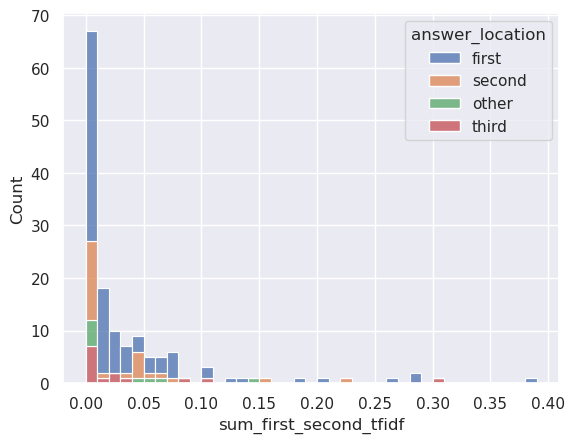

In [13]:
condition = (df["first_prob"] < 0.9) & (df["max_tfidf_prob"] < 0.9)
# (0.001 < df["first_tfidf"]) & (df["dist_1_2_rate"] < 0.5) & (20 < df["first_len"])
tmp_df = df.loc[condition]
print(f"all:{len(tmp_df)} wrong:{len(tmp_df[tmp_df['answer_location'] != 'first'])}")
sns.histplot(data=tmp_df, x="sum_first_second_tfidf", hue="answer_location", multiple="stack", binwidth=0.01)

In [58]:
df.loc[509]

prompt                 What is the approximate distance of NGC 7129 f...
A                                                         33 light years
B                                                            3,300 miles
C                                                       3,300 kilometers
D                                                        3.3 light years
E                                                        330 light years
answer                                                                 D
context                NGC 1052-DF2 > Distance > Follow-up observatio...
first_prob                                                      0.746239
second_prob                                                     0.334766
third_prob                                                      0.325025
prob_diff                                                       0.411472
prob_diff23                                                     0.009741
first_option_index                                 

In [56]:
df[condition]

,prompt,A,B,C,D,E,answer,context,first_prob,second_prob,...,third_len,dist_1_2,dist_1_2_rate,dist_1_3,dist_1_3_rate,answer_location,first_tfidf,second_tfidf,third_tfidf,should_swap
2,Which of the following statements accurately d...,The triskeles symbol was reconstructed as a fe...,The triskeles symbol is a representation of th...,The triskeles symbol is a representation of a ...,The triskeles symbol represents three interloc...,The triskeles symbol is a representation of th...,A,Triskelion > Use in European antiquity > Class...,0.811835,0.768880,...,367,203,0.602374,191,0.520436,first,0.004281,0.001612,0.004505,False
28,What is the evidence for the existence of a su...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The star S2 follows an elliptical orbit with a...,E,Supermassive black hole > Evidence > From the ...,0.740287,0.553895,...,242,81,0.122356,472,0.712991,second,0.080636,0.131271,0.060301,True
39,What is the synapstor or synapse transistor?,A device used to demonstrate a neuro-inspired ...,A device used to demonstrate a neuro-inspired ...,A device used to demonstrate a neuro-inspired ...,A device used to demonstrate a neuro-inspired ...,A device used to demonstrate a neuro-inspired ...,E,"Memristor > Implementations > In July 2008, Er...",0.457426,0.410623,...,132,4,0.029851,2,0.014925,second,0.007564,0.011028,0.006071,True
120,What is the Josephson effect?,The Josephson effect is a phenomenon exploited...,The Josephson effect is a phenomenon exploited...,The Josephson effect is a phenomenon exploited...,The Josephson effect is a phenomenon exploited...,The Josephson effect is a phenomenon exploited...,A,"Superconductivity > History > In 1962, Josephs...",0.771288,0.525297,...,218,2,0.009174,6,0.027523,first,0.172484,0.127286,0.071853,False
162,What is the definition of an improper rotation?,An improper rotation is the combination of a r...,An improper rotation is the combination of a r...,An improper rotation is the combination of a r...,An improper rotation is the combination of a r...,An improper rotation is the combination of a r...,B,Symmetry element > Rotational symmetry > An im...,0.851127,0.267641,...,368,5,0.014205,19,0.051630,first,0.080702,0.076954,0.071065,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182,Which of the following accurately describes a ...,A mastectomy is the surgical extraction of a s...,A mastectomy is a surgical procedure that remo...,A mastectomy is a surgical procedure carried o...,A mastectomy is the complete removal of one or...,A mastectomy is a surgical procedure performed...,E,Mastectomy > Mastectomy > Mastectomy is the me...,0.722356,0.551776,...,140,64,0.426667,78,0.557143,first,0.004245,0.007392,0.006036,False
1183,"What is the contrapositive of the statement ""i...","""if not B, then A""","""if not A, then not B""","""if B, then A""","""if B, then not A""","""if A, then not B""",B,Square of opposition > Set-theoretical interpr...,0.739776,0.605871,...,22,2,0.111111,6,0.272727,third,0.000000,0.000000,0.000000,False
1188,What should be the appropriate heating tempera...,90°C,130°C,75°C,150°C,110°C,C,Wax melter > Wax melter > The type of tank use...,0.531697,0.331454,...,5,2,0.500000,2,0.400000,second,0.000000,0.000000,0.000000,False
1195,What is the systematic name of the enzyme clas...,Medium-chain acyl-CoA hydrolase,Medium-chain hydrolase,Medium-chain acyl coenzyme A hydrolase,Medium-chain acyl-thioester hydrolase,ADP-dependent-medium-chain-acyl-CoA hydrolase,E,ADP-dependent medium-chain-acyl-CoA hydrolase ...,0.436878,0.373608,...,38,24,0.533333,25,0.555556,first,0.214575,0.038478,0.052983,False


In [49]:
df[
    (df["first_prob"] < 0.99)
    & (df["second_prob"] > 0.3)
    & (df["dist_1_2_rate"] < 0.1)
    & (20 < df["first_len"])
    & ((0.01 < df["first_tfidf"]) | (0.01 < df["second_tfidf"]))
    & (df["second_tfidf"] / (df["first_tfidf"] + 1e-9) > 1.0)
]

,prompt,A,B,C,D,E,answer,context,first_prob,second_prob,...,third_len,dist_1_2,dist_1_2_rate,dist_1_3,dist_1_3_rate,answer_location,first_tfidf,second_tfidf,third_tfidf,should_swap
258,What is the function of R1162-like plasmid ant...,Negatively regulates the RepI region of the pl...,Negatively regulates the RepI region of the pl...,Decreases the expression of the protein produc...,Positively regulates the RepI region of the pl...,Increases the expression of the protein produc...,A,R1162-like plasmid antisense RNA > R1162-like ...,0.966449,0.327922,...,109,2,0.020833,64,0.587156,second,0.009826,0.010275,0.002371,False
447,Which of the following statements accurately d...,Bis-gamma-glutamylcystine reductase acts on ga...,Bis-gamma-glutamylcystine reductase acts on ga...,Bis-gamma-glutamylcystine reductase acts on ga...,Bis-gamma-glutamylcystine reductase acts on bi...,Bis-gamma-glutamylcystine reductase acts on ga...,C,Bis-gamma-glutamylcystine reductase > Bis-gamm...,0.660314,0.475209,...,169,5,0.028736,74,0.437870,first,0.017582,0.030737,0.031767,True


In [45]:
df[
    (df["first_prob"] < 0.99)
    & (df["prob_diff"] < 0.2)
    & (df["dist_1_2_rate"] < 0.5)
    & (20 < df["first_len"])
    & ((0.01 < df["first_tfidf"]) | (0.01 < df["second_tfidf"]))
    & (df["second_tfidf"] / (df["first_tfidf"] + 1e-9) > 1.4)
]

,prompt,A,B,C,D,E,answer,context,first_prob,second_prob,...,third_len,dist_1_2,dist_1_2_rate,dist_1_3,dist_1_3_rate,answer_location,first_tfidf,second_tfidf,third_tfidf,should_swap
13,What is the Roche limit?,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,D,Roche limit > Roche limit > In celestial mecha...,0.947438,0.834348,...,160,139,0.460265,172,0.569536,second,0.012845,0.022513,0.003466,False
28,What is the evidence for the existence of a su...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The star S2 follows an elliptical orbit with a...,E,Supermassive black hole > Evidence > From the ...,0.740287,0.553895,...,242,81,0.122356,472,0.712991,second,0.080636,0.131271,0.060301,True
39,What is the synapstor or synapse transistor?,A device used to demonstrate a neuro-inspired ...,A device used to demonstrate a neuro-inspired ...,A device used to demonstrate a neuro-inspired ...,A device used to demonstrate a neuro-inspired ...,A device used to demonstrate a neuro-inspired ...,E,"Memristor > Implementations > In July 2008, Er...",0.457426,0.410623,...,132,4,0.029851,2,0.014925,second,0.007564,0.011028,0.006071,True


In [50]:
df[
    (df["second_prob"] > 0.4)
    & (df["dist_1_2_rate"] < 0.5)
    & (20 < df["first_len"])
    & ((0.01 < df["first_tfidf"]) | (0.01 < df["second_tfidf"]))
    & (df["second_tfidf"] / (df["first_tfidf"] + 1e-9) > 1.4)
]

,prompt,A,B,C,D,E,answer,context,first_prob,second_prob,...,third_len,dist_1_2,dist_1_2_rate,answer_location,first_tfidf,second_tfidf,should_swap,dist_1_3,dist_1_3_rate,third_tfidf
7,Which of the following statements accurately d...,The blocking temperature of an antiferromagnet...,The blocking temperature of an antiferromagnet...,The blocking temperature of an antiferromagnet...,The blocking temperature of an antiferromagnet...,The blocking temperature of an antiferromagnet...,D,Antiferromagnetism > Antiferromagnetic materia...,0.999612,0.476940,...,289,51,0.186131,first,0.003286,0.036598,False,65,0.224913,0.018249
13,What is the Roche limit?,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,The Roche limit is the distance at which tidal...,D,Roche limit > Roche limit > In celestial mecha...,0.947438,0.834348,...,160,139,0.460265,second,0.012845,0.022513,False,172,0.569536,0.003466
28,What is the evidence for the existence of a su...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The Milky Way galaxy has a supermassive black ...,The star S2 follows an elliptical orbit with a...,E,Supermassive black hole > Evidence > From the ...,0.740287,0.553895,...,242,81,0.122356,second,0.080636,0.131271,True,472,0.712991,0.060301
39,What is the synapstor or synapse transistor?,A device used to demonstrate a neuro-inspired ...,A device used to demonstrate a neuro-inspired ...,A device used to demonstrate a neuro-inspired ...,A device used to demonstrate a neuro-inspired ...,A device used to demonstrate a neuro-inspired ...,E,"Memristor > Implementations > In July 2008, Er...",0.457426,0.410623,...,132,4,0.029851,second,0.007564,0.011028,True,2,0.014925,0.006071
219,What are fenamates?,Organic compounds derived from anthranilic aci...,Organic compounds derived from 2-chlorobenzoic...,Organic compounds derived from acridone that s...,Organic compounds derived from 2-chlorobenzofu...,Organic compounds derived from fenamic acid th...,A,Fenamic acid > Fenamic acid > Fenamic acid is ...,0.847758,0.546900,...,95,63,0.488372,first,0.014271,0.027533,False,72,0.558140,0.001098


In [87]:
df["second_option_index"]

0       1
1       1
2       3
3       0
4       0
       ..
1195    3
1196    1
1197    2
1198    2
1199    4
Name: second_option_index, Length: 1200, dtype: int64

In [90]:
max_prob[df["should_swap"], df.loc[df["should_swap"], "second_option_index"]] = (
    max_prob[df["should_swap"], df.loc[df["should_swap"], "first_option_index"]] + 1.0
)

In [79]:
df.iloc[447]

prompt             Which of the following statements accurately d...
A                  Bis-gamma-glutamylcystine reductase acts on ga...
B                  Bis-gamma-glutamylcystine reductase acts on ga...
C                  Bis-gamma-glutamylcystine reductase acts on ga...
D                  Bis-gamma-glutamylcystine reductase acts on bi...
E                  Bis-gamma-glutamylcystine reductase acts on ga...
answer                                                             C
context            Bis-gamma-glutamylcystine reductase > Bis-gamm...
first_prob                                                  0.660314
second_prob                                                 0.475209
third_prob                                                  0.131103
prob_diff                                                   0.185105
prob_diff23                                                 0.344106
first_option                                                       C
second_option                     

In [65]:
df.iloc[179].C

"The difference in distance travelled by light from the planet (or its moon) to Earth when the Earth is at the point in its orbit that is closest to its planet than when the Earth is at the farthest point in its orbit, the difference in distance being the diameter of the Earth's orbit around the Sun."

In [66]:
df.iloc[179].E

"The difference in the gravitational pull of the planet on its moons when the Earth is at the point in its orbit that is closest to its planet than when the Earth is at the farthest point in its orbit, the difference in distance being the diameter of the Earth's orbit around the Sun."

In [67]:
df.iloc[179].context

'Speed of light > Measurement > Ole Christensen Rømer used an astronomical measurement to make the first quantitative estimate of the speed of light in the year 1676. When measured from Earth, the periods of moons orbiting a distant planet are shorter when the Earth is approaching the planet than when the Earth is receding from it. The distance travelled by light from the planet (or its moon) to Earth is shorter when the Earth is at the point in its orbit that is closest to its planet than when the Earth is at the farthest point in its orbit, the difference in distance being the diameter of the Earth\'s orbit around the Sun. The observed change in the moon\'s orbital period is caused by the difference in the time it takes light to traverse the shorter or longer distance. Rømer observed this effect for Jupiter\'s innermost major moon Io and deduced that light takes 22 minutes to cross the diameter of the Earth\'s orbit. Libration point orbit > Libration point orbit > In orbital mechanic